# Using custom input data

The GrIML package can be used with custom input data. This guide will outline what type of data can be used, and how it can be integrated.

## What type of features can be classified using GrIML?

GrIML has primarily been created to classify ice-marginal lakes across Greenland from satellite imagery. An ice-marginal lake is a water body in contact with an ice sheet, ice cap or glacier. It can be classified based on the following criteria:

- Size (in this case, an areal footprint extent) 
- Proximity to an ice margin

GrIML has primarily been developed so it can continue to be used for producing the [Greenland ice-marginal lake inventory](https://doi.org/10.22008/FK2/MBKW9N). In addition, a big motivation for its design and documentation is so that others can use its functionality to produce ice-marginal lakes across other regions of the world. 

Other cryosphere features may be classified using the criteria defined in GrIML, such as supraglacial lakes (which are water bodies present on the ice surface). Therefore, GrIML is not just limited to classifying one type of feature and we encourage users to explore GrIML's functionality and classification criteria to assess whether it is suitable for your needs.

## What type of input data can be used?

Input data has to be a **raster format file**, such as a `.tif`. This format should be compatible with [rasterio's open](https://rasterio.readthedocs.io/en/stable/api/rasterio.html#rasterio.open) functionality, which is used in GrIML to open the dataset. The function can be used to test that the input data is valid. Here, we will open a test data file over a section of North Greenland, which is provided in the [GrIML repo](https://github.com/GEUS-Glaciology-and-Climate/GrIML/).

In [7]:
import rasterio

infile = '../test/test_data/test_north_greenland.tif'

with rasterio.open(infile) as dataset:
    print(dataset.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 37888, 'height': 37888, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","3413"]]'), 'transform': Affine(10.0, 0.0, -406590.0,
       0.0, -10.0, -595270.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


The input data should be mapped across a **uniform projection**, such as a coordinate system associated with a satellite image or orthophoto. This coordinate system should be a standardised reference system. The rasterio package can be used to check that a defined projection string is valid. In the example here, we will check to see if EPSG:3005 is a valid projection name.

In [8]:
from rasterio.crs import CRS

crs = CRS.from_string("EPSG:3005")
print(crs)

EPSG:3005


The input data should contain a **binary classification of features**, with values of `0` signifying no classification and `1` signifying a positive classification.

In [9]:
infile = '../test/test_data/test_north_greenland.tif'

src = rasterio.open(infile)
print(src)

<open DatasetReader name='../test/test_data/test_north_greenland.tif' mode='r'>


You can plot the binary dataset using matplotlib. In this example, the test file is too big to plot and show so we will first clip the dataset to a defined window and plot this instead. This is purely for a visual check of the dataset, if needed.

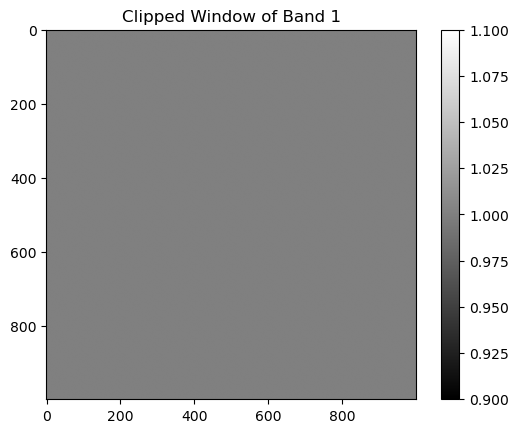

In [10]:
import matplotlib.pyplot as plt
from rasterio.windows import Window

with rasterio.open(infile) as src:
    
    # Define a window (start_x, start_y, width, height)
    window = Window(col_off=10000, row_off=10000, width=1000, height=1000)

    # Read band 1 from the window
    data = src.read(1, window=window)

# Plot the clipped data
plt.imshow(data, cmap='gray')
plt.title("Clipped Window of Band 1")
plt.colorbar()
plt.show()

## Example input data

If you have followed the [GEE script for classifying ice-marginal lakes](https://github.com/GEUS-Glaciology-and-Climate/GrIML/blob/main/gee_scripts/lake_classification.js) available through the GrIML repo, then the returned dataset is a `.tif` raster with coordinates in a defined projection. This dataset is from Greenland, with a projection in [EPSG:3413 Polar Stereographic](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection). The returned dataset consists of three bands representing binary classification using the following approaches:

- Multi-spectral classification from Sentinel-2
- Backscatter threshold classification from Sentinel-1
- Sink detection from ArcticDEM

Here we will open a test data file over a section of North Greenland, processed using the GEE script mentioned above. This test data file is provided in the [GrIML repo](https://github.com/GEUS-Glaciology-and-Climate/GrIML/). Let's first define the location of this raster file, which is located in the top level test directory in the repository.

In [14]:
# Define input binary raster
infile = '../test/test_data/test_north_greenland.tif'
print(infile)

../test/test_data/test_north_greenland.tif


The GrIML processing workflow starts by converting a binary raster classification to vectors, so first let's import this function.

In [15]:
from griml.convert import convert

The projection and band information is needed to perform the vector conversion. The projection is defined as a string with the EPSG reference name. The band information is provided as a list of dictionaries. In this example, each band signifies a binary classification using each of the classification methods. If the image only consists of one band then a list still needs to be provided, but should only contain one dictionary with the relevant information.

In [16]:
# Define projection of input binary raster
proj = 'EPSG:3413'

# Define band information of binary raster
band_info = [{'b_number':1, 'method':'VIS', 'source':'S2'},
            {'b_number':2, 'method':'SAR', 'source':'S1'},
            {'b_number':3, 'method':'DEM', 'source':'ARCTICDEM'}]

print(proj)
print(band_info)

EPSG:3413
[{'b_number': 1, 'method': 'VIS', 'source': 'S2'}, {'b_number': 2, 'method': 'SAR', 'source': 'S1'}, {'b_number': 3, 'method': 'DEM', 'source': 'ARCTICDEM'}]


Along with this, the acquisition time range is needed. In this example, classifications were made from averaged satellite imagery acquired between 01-07-2017 and 31-08-2017. In the case that classifications are defined from one image/scene, the start and end time range should be defined as the same date.

In [17]:
# Define start and end dates of acquisitions from which rasters are created
start='20170701'
end='20170831'

print(start)
print(end)

20170701
20170831


The file can be converted from raster to vector classifications using the `convert` function and the input variables.

Note that a single raster file is wrapped as a list, as the `convert` function expects a list of rasters normally. We recommend using `glob` to generate a list of rasters from converting, if you wish to convert multiple classifications.

In [18]:
# Convert binary raster to vectors
out1 = convert([infile], proj, band_info, start, end)
print(out1)


1. Converting test_north_greenland.tif
Retrieving vectors from band S2...
Retrieving vectors from band S1...
Retrieving vectors from band ARCTICDEM...
[                                                 geometry method     source  \
row_id                                                                        
1       POLYGON ((-240140 -742150, -240140 -742190, -2...    VIS         S2   
2       POLYGON ((-240300 -742190, -240300 -742200, -2...    VIS         S2   
3       POLYGON ((-240170 -742190, -240170 -742220, -2...    VIS         S2   
4       POLYGON ((-241180 -742240, -241180 -742260, -2...    VIS         S2   
5       POLYGON ((-239900 -742250, -239900 -742260, -2...    VIS         S2   
...                                                   ...    ...        ...   
702096  POLYGON ((-356570 -974130, -356560 -974130, -3...    DEM  ARCTICDEM   
702097  POLYGON ((-352970 -974040, -352960 -974040, -3...    DEM  ARCTICDEM   
702098  POLYGON ((-309630 -974140, -309630 -974150, -3...